In [181]:
# Sentiment Analysis for Stock Market Predictions

# Objective:
# Incorporate market sentiment from financial news or tweets to enhance stock price predictions.

# Steps:
# 1. Collect financial news or tweets using APIs
# 2. Perform sentiment analysis using NLP tools like TextBlob or VADER.
# 3. Integrate sentiment scores into the existing stock prediction dataset.

In [182]:
# Import necessary libraries
import pandas as pd
import numpy as np
import time
from datetime import datetime
import logging
import os
import requests  # For API calls
from textblob import TextBlob  # For sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer  # Alternative sentiment analysis tool
import matplotlib.pyplot as plt  
from datetime import datetime  # For handling timestamps
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from nltk import download

In [183]:
import requests

url = "https://newsapi.org/v2/everything?q=Apple&apiKey=66ffd34668864359ad468c8cf20f68dc"
response = requests.get(url)

if response.status_code == 200:
    print("Request successful!")
    print(response.json())
else:
    print(f"Error fetching data: {response.status_code}")


Request successful!
{'status': 'ok', 'totalResults': 42785, 'articles': [{'source': {'id': None, 'name': 'Yahoo Entertainment'}, 'author': 'Amy Skorheim', 'title': 'Black Friday Apple deals 2024: The best Apple sales on iPads, AirPods, Apple Watches and MacBooks', 'description': 'Apple devices have a few things in common: they’re well-designed, solidly built and easily connect with one another. But chances are, if it bears the Apple logo, it’s not cheap. That’s why promos like Black Friday are always worth checking out if you’re in th…', 'url': 'https://consent.yahoo.com/v2/collectConsent?sessionId=1_cc-session_5b50f93c-f2e5-4f39-87c2-8667512a5599', 'urlToImage': None, 'publishedAt': '2024-11-19T16:51:43Z', 'content': "If you click 'Accept all', we and our partners, including 237 who are part of the IAB Transparency &amp; Consent Framework, will also store and/or access information on a device (in other words, use … [+678 chars]"}, {'source': {'id': None, 'name': 'Yahoo Entertainment'}

In [184]:
# 1. Collect financial news or tweets using APIs

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def fetch_news(api_key, query, from_date, to_date, page_size=100, max_pages=5):
    """
    Fetch recent financial news articles using the NewsAPI with improved error handling and pagination.
    
    Parameters:
    - api_key: str : Your API key for NewsAPI.
    - query: str : The search query (e.g., stock ticker or company name).
    - from_date: str : Start date for the news search (YYYY-MM-DD).
    - to_date: str : End date for the news search (YYYY-MM-DD).
    - page_size: int : Number of articles per page (default: 100).
    - max_pages: int : Maximum number of pages to fetch (default: 5).

    Returns:
    - pd.DataFrame : A cleaned and structured DataFrame containing news headlines and related metadata.
    """
    base_url = "https://newsapi.org/v2/everything"
    headers = {"User-Agent": "Mozilla/5.0"}
    all_articles = []
    
    try:
        for page in range(1, max_pages + 1):
            params = {
                "q": query,
                "from": from_date,
                "to": to_date,
                "pageSize": page_size,
                "page": page,
                "apiKey": api_key,
            }
            response = requests.get(base_url, headers=headers, params=params)
            
            if response.status_code == 200:
                articles = response.json().get('articles', [])
                if not articles:
                    break  # Exit loop if no articles found
                all_articles.extend(articles)
                logging.info(f"Page {page} fetched successfully.")
            elif response.status_code == 401:
                logging.error("Invalid API key. Please check your API key and try again.")
                break
            elif response.status_code == 426:
                logging.error("API endpoint requires upgrade.")
                break
            else:
                logging.error(f"Error fetching data: {response.status_code}")
                logging.error(f"Response Text: {response.text}")
                break  # Exit loop on error
            
            time.sleep(1)  # To avoid hitting rate limits
        
        if all_articles:
            # Convert articles into a DataFrame
            df = pd.DataFrame({
                'published_at': [article['publishedAt'] for article in all_articles],
                'headline': [article['title'] for article in all_articles],
                'source': [article['source']['name'] for article in all_articles],
                'description': [article.get('description') for article in all_articles],
                'url': [article['url'] for article in all_articles]
            })
            
            # Convert dates to datetime
            df['published_at'] = pd.to_datetime(df['published_at'])
            
            # Drop duplicates and missing headlines
            df = df.drop_duplicates(subset=['headline']).dropna(subset=['headline'])
            
            # Filter articles containing the query in the headline or description
            query_filter = df['headline'].str.contains(query, case=False, na=False) | \
                           df['description'].str.contains(query, case=False, na=False)
            df = df[query_filter]
            
            if df.empty:
                logging.warning("No relevant articles found after filtering.")
            else:
                logging.info(f"Number of relevant articles fetched: {len(df)}")
            
            return df
        else:
            logging.warning("No articles found.")
            return pd.DataFrame()
    
    except Exception as e:
        logging.error(f"An exception occurred: {e}")
        return pd.DataFrame()

def save_data_to_csv(df, filename="data/fetched_news.csv"):
    """
    Save the DataFrame to a CSV file.
    
    Parameters:
    - df: pd.DataFrame : The DataFrame to save.
    - filename: str : The name of the CSV file (default: fetched_news.csv).
    """
    try:
        if not df.empty:
            df.to_csv(filename, index=False)
            logging.info(f"Data successfully saved to {filename}.")
        else:
            logging.warning("No data to save. The DataFrame is empty.")
    except Exception as e:
        logging.error(f"Error saving data to CSV: {e}")

if __name__ == "__main__":
    api_key = "66ffd34668864359ad468c8cf20f68dc"  # Replace with your actual API key
    query = "Apple Inc."
    from_date = "2024-11-23"
    to_date = "2024-11-30"
    
    # Fetch the data
    news_data = fetch_news(api_key, query, from_date, to_date)
    
    if not news_data.empty:
        # Print preview of fetched data
        print("Fetched News Data:")
        print(news_data.head())
        
        # Save to CSV
        save_data_to_csv(news_data)
    else:
        print("No data fetched. Please check your query or API settings.")


2024-12-08 22:54:55,332 - INFO - Page 1 fetched successfully.
2024-12-08 22:54:56,437 - ERROR - API endpoint requires upgrade.
2024-12-08 22:54:56,440 - INFO - Number of relevant articles fetched: 39
2024-12-08 22:54:56,442 - INFO - Data successfully saved to data/fetched_news.csv.


Fetched News Data:
                published_at  \
7  2024-11-27 17:21:15+00:00   
9  2024-11-26 08:33:27+00:00   
12 2024-11-24 13:22:44+00:00   
14 2024-11-25 10:21:08+00:00   
15 2024-11-27 05:59:36+00:00   

                                             headline               source  \
7           How To Earn $500 A Month From Apple Stock  Yahoo Entertainment   
9   Tim Cook Joins US Executives To Attend China E...           Biztoc.com   
12  Is Apple Inc. (AAPL) Still a Key Fixture in Wa...  Yahoo Entertainment   
14  Apple’s Cook Joins CEO Summit with China Premi...  Yahoo Entertainment   
15  Apple Misses Out on Big 2024 Smartphone Market...  Yahoo Entertainment   

                                          description  \
7   Apple Inc. (NASDAQ:AAPL) shares closed slightl...   
9   Amid growing concerns over potential trade ten...   
12                                               None   
14  (Bloomberg) -- Apple Inc. Chief Executive Offi...   
15  (Bloomberg) -- Global smartpho

In [185]:
# Step 2: Perform sentiment analysis on fetched news headlines

nltk.download('vader_lexicon', quiet=True)

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


def preprocess_headlines(headlines):
    """
    Preprocess headlines to ensure all values are strings.

    Parameters:
    - headlines: list or pd.Series : A list or Series of news headlines.

    Returns:
    - list : A cleaned list of headlines where all entries are strings.
    """
    return [str(headline) if pd.notnull(headline) else "" for headline in headlines]

def compute_sentiment_scores(headlines, analyzer):
    """
    Compute sentiment scores for a list of headlines using VADER.

    Parameters:
    - headlines: list or pd.Series : A list or Series of news headlines.
    - analyzer: SentimentIntensityAnalyzer object.

    Returns:
    - pd.DataFrame : A DataFrame containing sentiment scores for each headline.
    """
    sentiment_scores = []
    for headline in headlines:
        scores = analyzer.polarity_scores(headline)
        sentiment_scores.append(scores)
    return pd.DataFrame(sentiment_scores)

def perform_sentiment_analysis(news_data_path, output_path):
    """
    Load news data, perform sentiment analysis, and save the results to CSV.

    Parameters:
    - news_data_path: str : Path to the CSV file containing fetched news data.
    - output_path: str : Path to save the sentiment-enriched news CSV.

    Returns:
    - pd.DataFrame: DataFrame of news data with sentiment scores.
    """
    if not os.path.exists(news_data_path):
        logging.error(f"News data file not found at {news_data_path}. Please check the path.")
        return pd.DataFrame()

    news_data = pd.read_csv(news_data_path)
    if news_data.empty:
        logging.warning("No news data found. Please ensure the CSV file is not empty.")
        return pd.DataFrame()

    # Initialize VADER sentiment analyzer
    analyzer = SentimentIntensityAnalyzer()

    # Ensure 'headline' column exists
    if 'headline' not in news_data.columns:
        logging.error("The 'headline' column is missing from the news data.")
        return pd.DataFrame()

    # Preprocess headlines
    cleaned_headlines = preprocess_headlines(news_data['headline'])

    # Compute sentiment scores
    sentiment_scores = compute_sentiment_scores(cleaned_headlines, analyzer)

    # Merge sentiment scores with the news data
    news_data = pd.concat([news_data.reset_index(drop=True), sentiment_scores], axis=1)

    # Save the results
    news_data.to_csv(output_path, index=False)
    logging.info(f"Sentiment analysis completed. Results saved to {output_path}.")

    return news_data

# Example usage of the sentiment analysis step:
sentiment_enriched_news_path = "data/fetched_news_with_sentiment.csv"
news_data = perform_sentiment_analysis("data/fetched_news.csv", sentiment_enriched_news_path)

if not news_data.empty:
    print("Sentiment Analysis Results Preview:")
    print(news_data[['headline', 'pos', 'neg', 'neu', 'compound']].head())
else:
    print("No data available for sentiment analysis.")

2024-12-08 22:54:56,458 - INFO - Sentiment analysis completed. Results saved to data/fetched_news_with_sentiment.csv.


Sentiment Analysis Results Preview:
                                            headline  pos    neg    neu  \
0          How To Earn $500 A Month From Apple Stock  0.0  0.000  1.000   
1  Tim Cook Joins US Executives To Attend China E...  0.0  0.133  0.867   
2  Is Apple Inc. (AAPL) Still a Key Fixture in Wa...  0.0  0.000  1.000   
3  Apple’s Cook Joins CEO Summit with China Premi...  0.0  0.000  1.000   
4  Apple Misses Out on Big 2024 Smartphone Market...  0.0  0.160  0.840   

   compound  
0    0.0000  
1   -0.3818  
2    0.0000  
3    0.0000  
4   -0.2263  


In [186]:
# Improved Step 3: Integrate sentiment scores with stock data
def integrate_sentiment_with_stock(stock_data_path, news_data_path, output_path):
    """
    Integrate sentiment scores into stock data by matching dates.
    
    Parameters:
    - stock_data_path: str : Path to stock data CSV.
    - news_data_path: str : Path to news data CSV with sentiment scores.
    - output_path: str : Path to save the integrated dataset.
    
    Returns:
    - pd.DataFrame : The integrated DataFrame.
    """
    try:
        # Load stock data
        stock_data = pd.read_csv(stock_data_path)
        stock_data['Date'] = pd.to_datetime(stock_data['Date'], errors='coerce').dt.date
        
        # Load sentiment data
        news_data = pd.read_csv(news_data_path)
        news_data['published_at'] = pd.to_datetime(news_data['published_at'], errors='coerce').dt.date

        # Drop invalid rows
        stock_data.dropna(subset=['Date'], inplace=True)
        news_data.dropna(subset=['published_at'], inplace=True)

        # Filter news data within stock data range
        date_range = (news_data['published_at'] >= stock_data['Date'].min()) & \
                     (news_data['published_at'] <= stock_data['Date'].max())
        news_data = news_data[date_range]

        # Fill missing sentiment columns
        sentiment_columns = ['neg', 'neu', 'pos', 'compound']
        for col in sentiment_columns:
            if col not in news_data.columns:
                news_data[col] = 0.0

        # Merge datasets on date
        merged_data = pd.merge(
            stock_data,
            news_data,
            left_on='Date',
            right_on='published_at',
            how='left'
        )

        # Save integrated data
        merged_data.to_csv(output_path, index=False)
        logging.info(f"Integrated data saved to {output_path}.")
        return merged_data

    except Exception as e:
        logging.error(f"Error during integration: {e}")
        return pd.DataFrame()

# Use the function
merged_data_path = "data/AAPL_with_sentiment.csv"
merged_data = integrate_sentiment_with_stock("data/AAPL_data_with_beta.csv", sentiment_enriched_news_path, merged_data_path)

# Check the output
if not merged_data.empty:
    print("Sample of Integrated Data:")
    print(merged_data.head())
else:
    print("No integrated data available.")


2024-12-08 22:54:56,509 - INFO - Integrated data saved to data/AAPL_with_sentiment.csv.


Sample of Integrated Data:
         Date          Adj Close              Close               High  \
0  2020-01-02   72.7960205078125   75.0875015258789   75.1500015258789   
1  2020-01-03   72.0882797241211  74.35749816894531   75.1449966430664   
2  2020-01-06  72.66270446777344  74.94999694824219  74.98999786376953   
3  2020-01-07  72.32097625732422  74.59750366210938   75.2249984741211   
4  2020-01-08  73.48435974121094  75.79750061035156  76.11000061035156   

                 Low               Open     Volume  Stock Return  \
0  73.79750061035156  74.05999755859375  135480400           NaN   
1             74.125   74.2874984741211  146322800     -0.009722   
2            73.1875  73.44750213623047  118387200      0.007968   
3  74.37000274658203  74.95999908447266  108872000     -0.004703   
4  74.29000091552734  74.29000091552734  132079200      0.016086   

   Rolling Beta published_at headline source description  url  neg  neu  pos  \
0           NaN          NaN      NaN  

In [187]:
# Inspect the news data for missing or invalid dates
news_data = pd.read_csv("data/fetched_news_with_sentiment.csv")

# Check for null values
print("Null values in 'published_at':", news_data['published_at'].isnull().sum())

# Preview the column
print(news_data['published_at'].head())

# Check unique formats if possible
print(news_data['published_at'].dropna().unique()[:10])

# Drop rows with null or invalid dates
news_data = news_data.dropna(subset=['published_at'])

# Convert 'published_at' to datetime
news_data['published_at'] = pd.to_datetime(news_data['published_at'], errors='coerce')

# Drop rows where conversion failed
news_data = news_data.dropna(subset=['published_at'])

# Confirm the column is now valid
print("Cleaned news data date range:", news_data['published_at'].min(), "to", news_data['published_at'].max())


Null values in 'published_at': 0
0    2024-11-27 17:21:15+00:00
1    2024-11-26 08:33:27+00:00
2    2024-11-24 13:22:44+00:00
3    2024-11-25 10:21:08+00:00
4    2024-11-27 05:59:36+00:00
Name: published_at, dtype: object
['2024-11-27 17:21:15+00:00' '2024-11-26 08:33:27+00:00'
 '2024-11-24 13:22:44+00:00' '2024-11-25 10:21:08+00:00'
 '2024-11-27 05:59:36+00:00' '2024-11-24 21:53:03+00:00'
 '2024-11-25 09:38:08+00:00' '2024-11-27 08:10:52+00:00'
 '2024-11-24 08:02:51+00:00' '2024-11-27 08:10:50+00:00']
Cleaned news data date range: 2024-11-24 08:02:48+00:00 to 2024-11-30 09:17:02+00:00


In [ ]:
# Improved Step 3: Integrate sentiment scores with stock data
def integrate_sentiment_with_stock(stock_data_path, news_data_path, output_path):
    """
    Integrate sentiment scores into stock data by matching dates.
    
    Parameters:
    - stock_data_path: str : Path to stock data CSV.
    - news_data_path: str : Path to news data CSV with sentiment scores.
    - output_path: str : Path to save the integrated dataset.
    
    Returns:
    - pd.DataFrame : The integrated DataFrame.
    """
    try:
        # Load stock data
        stock_data = pd.read_csv(stock_data_path)
        stock_data['Date'] = pd.to_datetime(stock_data['Date'], errors='coerce').dt.date
        
        # Load sentiment data
        news_data = pd.read_csv(news_data_path)
        news_data['published_at'] = pd.to_datetime(news_data['published_at'], errors='coerce').dt.date

        # Drop invalid rows
        stock_data.dropna(subset=['Date'], inplace=True)
        news_data.dropna(subset=['published_at'], inplace=True)

        # Filter news data within stock data range
        date_range = (news_data['published_at'] >= stock_data['Date'].min()) & \
                     (news_data['published_at'] <= stock_data['Date'].max())
        news_data = news_data[date_range]

        # Fill missing sentiment columns
        sentiment_columns = ['neg', 'neu', 'pos', 'compound']
        for col in sentiment_columns:
            if col not in news_data.columns:
                news_data[col] = 0.0

        # Merge datasets on date
        merged_data = pd.merge(
            stock_data,
            news_data,
            left_on='Date',
            right_on='published_at',
            how='left'
        )

        # Save integrated data
        merged_data.to_csv(output_path, index=False)
        logging.info(f"Integrated data saved to {output_path}.")
        return merged_data

    except Exception as e:
        logging.error(f"Error during integration: {e}")
        return pd.DataFrame()

# Use the function
merged_data_path = "data/AAPL_with_sentiment.csv"
merged_data = integrate_sentiment_with_stock("data/AAPL_data_with_beta.csv", sentiment_enriched_news_path, merged_data_path)

# Check the output
if not merged_data.empty:
    print("Sample of Integrated Data:")
    print(merged_data.head())
else:
    print("No integrated data available.")


2024-12-08 22:54:56,509 - INFO - Integrated data saved to data/AAPL_with_sentiment.csv.


Sample of Integrated Data:
         Date          Adj Close              Close               High  \
0  2020-01-02   72.7960205078125   75.0875015258789   75.1500015258789   
1  2020-01-03   72.0882797241211  74.35749816894531   75.1449966430664   
2  2020-01-06  72.66270446777344  74.94999694824219  74.98999786376953   
3  2020-01-07  72.32097625732422  74.59750366210938   75.2249984741211   
4  2020-01-08  73.48435974121094  75.79750061035156  76.11000061035156   

                 Low               Open     Volume  Stock Return  \
0  73.79750061035156  74.05999755859375  135480400           NaN   
1             74.125   74.2874984741211  146322800     -0.009722   
2            73.1875  73.44750213623047  118387200      0.007968   
3  74.37000274658203  74.95999908447266  108872000     -0.004703   
4  74.29000091552734  74.29000091552734  132079200      0.016086   

   Rolling Beta published_at headline source description  url  neg  neu  pos  \
0           NaN          NaN      NaN  

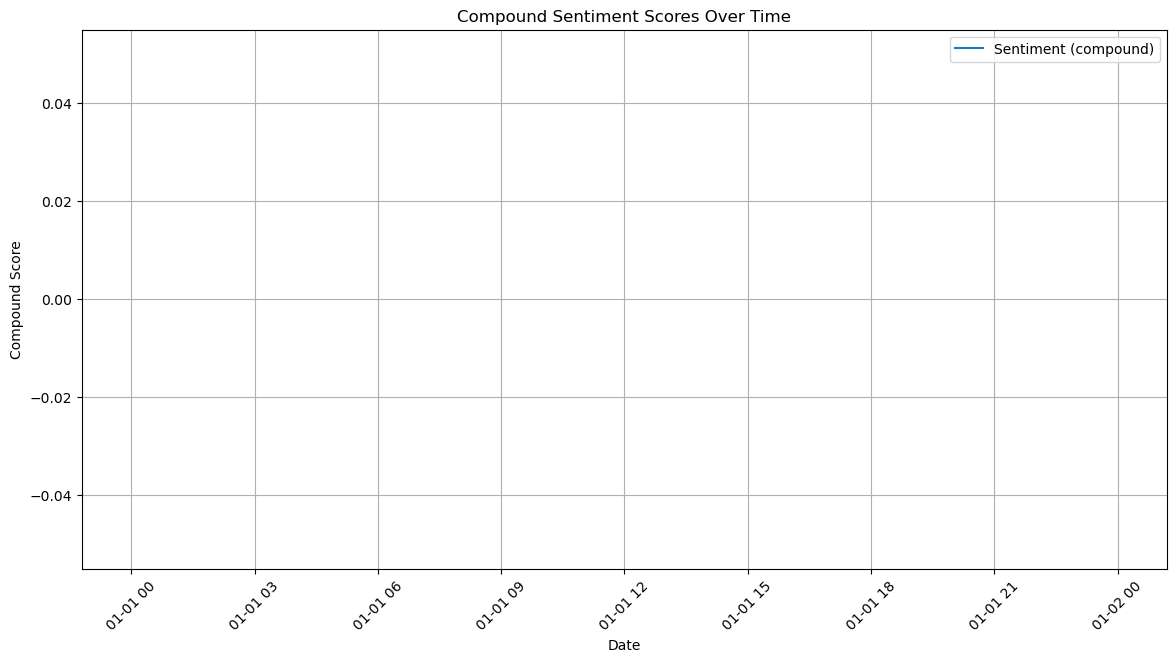

In [188]:
# Enhanced Step 4: Visualization
def visualize_sentiment_over_time(merged_data, date_column='Date', sentiment_column='compound'):
    """
    Visualize sentiment scores over time with enhancements.

    Parameters:
    - merged_data: pd.DataFrame : The dataset containing stock and sentiment data.
    - date_column: str : The name of the date column.
    - sentiment_column: str : The name of the sentiment column to plot.
    """
    try:
        if merged_data.empty:
            logging.warning("Merged data is empty. Visualization aborted.")
            return

        if date_column not in merged_data.columns or sentiment_column not in merged_data.columns:
            logging.warning(f"Columns '{date_column}' or '{sentiment_column}' not found.")
            return

        # Plot
        plt.figure(figsize=(14, 7))
        plt.plot(merged_data[date_column], merged_data[sentiment_column], label=f'Sentiment ({sentiment_column})')
        plt.title(f"{sentiment_column.capitalize()} Sentiment Scores Over Time")
        plt.xlabel("Date")
        plt.ylabel(f"{sentiment_column.capitalize()} Score")
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.show()

    except Exception as e:
        logging.error(f"Error during visualization: {e}")

# Use the function
if not merged_data.empty:
    visualize_sentiment_over_time(merged_data, date_column='Date', sentiment_column='compound')
else:
    print("Visualization cannot proceed due to empty data.")


In [189]:
# Further improvement:
# - Implement more advanced sentiment models like BERT or FinBERT for better accuracy.
# - Perform sentiment analysis on tweets for real-time market analysis.
# - Analyze correlations between sentiment scores and stock price movements.